In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'vbiv' # ticker symbol
train = 1 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'aapl':'12/12/1980' # Updated 1/1/21
               , 'acy': '01/18/1998' # Updated 1/1/21
               , 'amd': '03/17/1980' # Updated 1/1/21
               , 'baba': '09/15/2014' # Updated 1/1/21
               , 'bac': '02/19/1973' # Updated 1/1/21
               , 'crm': '06/23/2004' # Updated 1/1/21
               , 'esgv': '09/16/2018' # Updated 1/1/21
               , 'goog': '08/16/2004' # Updated 1/1/21
               , 'ibm': '01/02/1962' # Updated 1/1/21
               , 'idex': '05/23/2007' # Updated 1/1/21
               , 'intc': '03/16/1980' # Updated 1/1/21
               , 'iyw': '05/15/2000' # Updated 1/1/21
               , 'ma': '05/21/2006' # Updated 1/1/21
               , 'msft': '03/10/1986' # Updated 1/1/21
               , 'nio': '09/10/2018' # Updated 1/1/21
               , 'nvda': '01/22/1999' # Updated 1/1/21
               , 'pypl': '07/05/2015' # Updated 1/1/21
               , 'tsla': '06/29/2010' # Updated 1/1/21
               , 'v': '03/16/2008' # Updated 1/1/21
               , 'vbiv': '09/04/2002' # Updated 1/1/21
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-17,3.3800,3.1209,3.2400,3.350,5801022.0,3.350,-0.033951,0.083021,0.050157,0.042807,0.012784,-1
2020-12-18,3.4200,3.2300,3.4000,3.235,10865689.0,3.235,0.048529,0.058824,-0.034328,0.047384,0.007503,1
2020-12-21,3.5300,3.1400,3.2000,3.480,9817215.0,3.480,-0.087500,0.124204,0.075734,0.050176,0.009231,-1
2020-12-22,3.6300,3.3300,3.5000,3.500,8316824.0,3.500,0.000000,0.090090,0.005747,0.046261,0.015770,-1
2020-12-23,3.5000,3.2701,3.4900,3.330,6691541.0,3.330,0.045845,0.070304,-0.048571,0.053261,0.009748,-1
2020-12-24,3.3599,3.1200,3.3135,3.120,3790964.0,3.120,0.058397,0.076891,-0.063063,0.055794,-0.012896,-1
2020-12-28,3.1200,2.8400,3.0971,2.850,9325828.0,2.850,0.079784,0.098592,-0.086538,0.064943,-0.023338,1
2020-12-29,2.9500,2.7400,2.8900,2.810,6173210.0,2.810,0.027682,0.076642,-0.014035,0.037181,-0.041292,1
2020-12-30,3.0386,2.8200,2.8200,3.020,6003404.0,3.020,-0.070922,0.077518,0.074733,0.062903,-0.027495,-1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
if train == 1:
    a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)
elif train == 0:
    pass

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.64060712 0.64060712 0.64060712]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

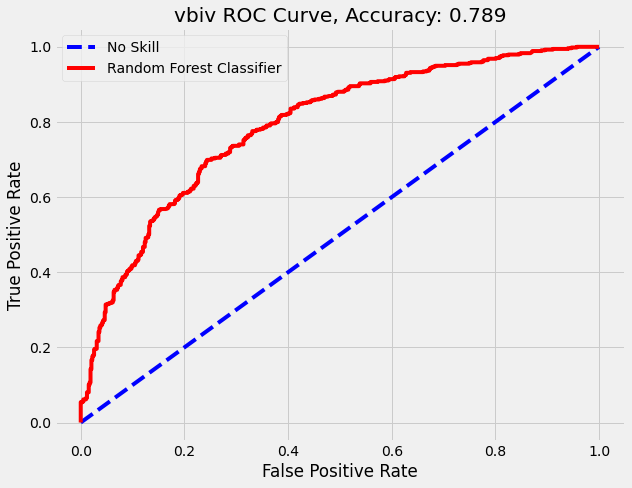

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

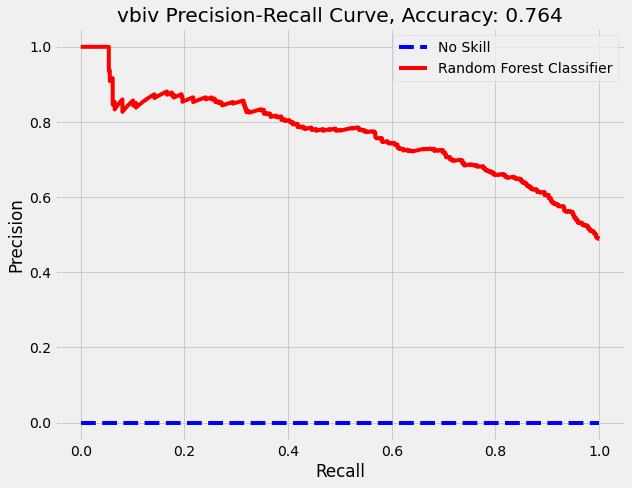

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

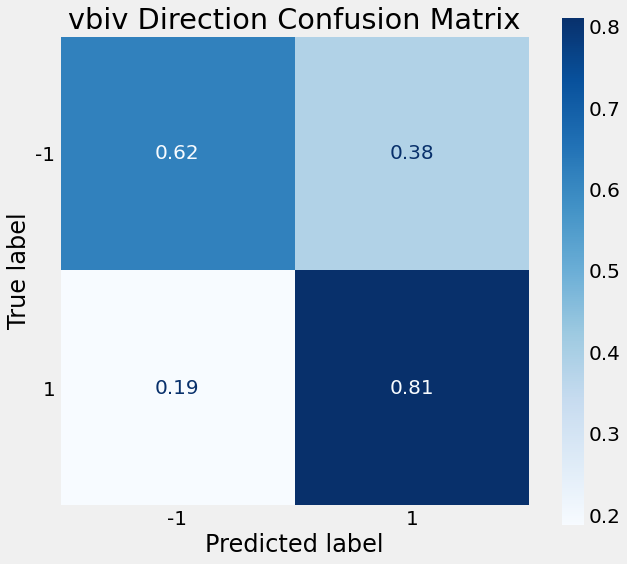

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6587829477709872'

### Prediction...

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          3.010000e+00
Low           2.750000e+00
Open          2.990000e+00
Close         2.750000e+00
Volume        6.996831e+06
Adj Close     2.750000e+00
oc            8.026756e-02
hl            9.454545e-02
adj          -8.940397e-02
5stdev_adj    6.870633e-02
5sma_adj     -3.566149e-02
direction    -1.000000e+00
Name: 2020-12-31 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc            0.080268
hl            0.094545
5stdev_adj    0.068706
5sma_adj     -0.035661
Name: 2020-12-31 00:00:00, dtype: float64

In [13]:
stock_df['adj'].describe()

count    4472.000000
mean        0.438094
std         2.303438
min        -0.976591
25%        -0.030925
50%         0.000000
75%         0.026805
max        47.004519
Name: adj, dtype: float64

In [14]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy vbiv


### Strategy Returns...

In [15]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-24,3.3599,3.12,3.3135,3.12,3790964.0,3.12,0.058397,0.076891,-0.063063,0.055794,-0.012896,-1,1,-0.086538
2020-12-28,3.1200,2.84,3.0971,2.85,9325828.0,2.85,0.079784,0.098592,-0.086538,0.064943,-0.023338,1,1,-0.014035
2020-12-29,2.9500,2.74,2.8900,2.81,6173210.0,2.81,0.027682,0.076642,-0.014035,0.037181,-0.041292,1,1,0.074733
2020-12-30,3.0386,2.82,2.8200,3.02,6003404.0,3.02,-0.070922,0.077518,0.074733,0.062903,-0.027495,-1,-1,0.089404
2020-12-31,3.0100,2.75,2.9900,2.75,6996831.0,2.75,0.080268,0.094545,-0.089404,0.068706,-0.035661,-1,1,0.000000


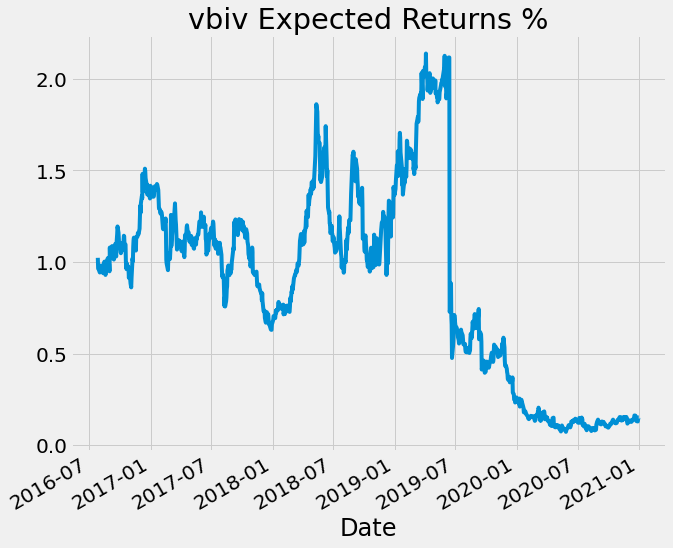

In [17]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

0.6747447840638896

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

-0.8910891089108911

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/